# Ensemble learning and Random Forests
 ## introduction
  __"the wisdom of the crowd"__  if you have a complicated question and you randomly pick thousands of people and ask them , most probably you will get an answer that is better than an expert.
  of course provided that those people you choose are (iid) independent and identically distributed.


  we can apply the same idea over models! why not have as much models as we can and then aggregate the final answer based on all of them! 

  ## voting classifiers 
  one way we can achieve the idea mentioned above is through this technique , simply you train n models and you take the majority of them , as we will know later this is called hard voting  
   
 let's see how to implement this idea with sklearn 

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier

x , y = make_moons(noise=.4 , n_samples=  10_000)
x_train , x_test , y_train , y_test = train_test_split(x, y ,
                                                       test_size= 0.3)


this is how the dataset looks like  

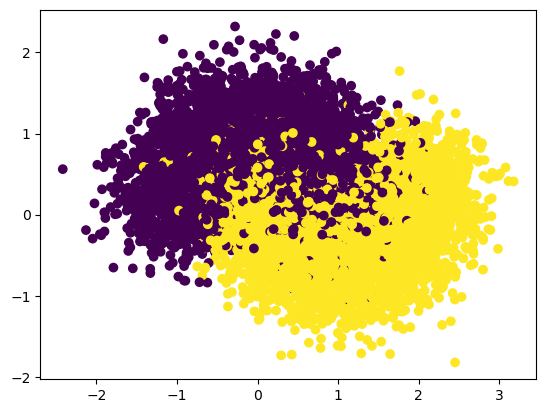

In [31]:
from matplotlib import pyplot as plt 
plt.scatter(x[:,0 ] , x [: ,1] , c = y)
plt.show()

In [32]:
log_clf = LogisticRegression() 
svm_clf = SVC(probability= True) 
tree_clf = DecisionTreeClassifier() 

voting_clf = VotingClassifier(
    estimators =[ ('log' , log_clf) , 
                  ('svm' , svm_clf) , 
                  ('tree' , tree_clf)
                  ] , 
    voting = 'hard'  , n_jobs=-1
    

) 
voting_clf.fit(x_train , y_train)

VotingClassifier(estimators=[('log', LogisticRegression()),
                             ('svm', SVC(probability=True)),
                             ('tree', DecisionTreeClassifier())],
                 n_jobs=-1)

now let's compare the performance of voting classifiers vs individual classifiers 

In [33]:
from sklearn.metrics import accuracy_score

for clf  in (log_clf , svm_clf , tree_clf , voting_clf):
    clf.fit(x_train , y_train)
    y_pred =clf.predict(x_test)
    score = accuracy_score(y_test , y_pred)
    print(clf.__class__.__name__ , score)

LogisticRegression 0.8286666666666667
SVC 0.8686666666666667
DecisionTreeClassifier 0.8033333333333333
VotingClassifier 0.8566666666666667


😂 not the most promising results as svm is better than the voting ! but you got the idea .
now let's tree with `voting = "soft"` and see ! 

In [34]:
log_clf = LogisticRegression() 
svm_clf = SVC(probability= True) 
tree_clf = DecisionTreeClassifier() 

voting_clf = VotingClassifier(
    estimators =[ ('log' , log_clf) , 
                  ('svm' , svm_clf) , 
                  ('tree' , tree_clf)
                  ] , 
    voting = 'soft'  , n_jobs=-1
    

) 
voting_clf.fit(x_train , y_train)

VotingClassifier(estimators=[('log', LogisticRegression()),
                             ('svm', SVC(probability=True)),
                             ('tree', DecisionTreeClassifier())],
                 n_jobs=-1, voting='soft')

In [35]:

for clf  in (log_clf , svm_clf , tree_clf , voting_clf):
    clf.fit(x_train , y_train)
    y_pred =clf.predict(x_test)
    score = accuracy_score(y_test , y_pred)
    print(clf.__class__.__name__ , score)

LogisticRegression 0.8286666666666667
SVC 0.8686666666666667
DecisionTreeClassifier 0.808
VotingClassifier 0.8513333333333334


😂 it should have been better than the hard voting , this is usually the case but Ml is just trial and error ! 

# Bagging and pasting 
remember the term __wisdom of the crowd__ we mentioned at the beginning , we will literally do it here .
we would train n models over different chunks of the dataset and aggregate their results .
each model with sample m different samples form the dataset ( if the sample is without replacement this is called Pasting `bootstrap = False` , if the sample is with replacement this is called Bagging `bootstrap = True`)

__few notes about the code below__
- `estimator` is the estimator we will use bagging or pasting over it 
- `n_estimator` is the number of variants of that estimator we will be using
- `max_samples` is the max number of samples each estimator will be trained on
- `n_jobs =-1`  telling sklearn to use all available cores  

In [36]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bag_clf = BaggingClassifier(
    estimator= DecisionTreeClassifier() , 
    n_estimators= 500 , 
    max_samples= 1000 , 
    bootstrap=True ,
     n_jobs= -1 , 
)
bag_clf.fit(x_train , y_train)
y_predict = bag_clf.predict(x_test)
score = accuracy_score(y_test , y_predict)
score 

0.86

## out of bag evaluation (oob)
since we are sampling from the dataset we have , there would be a portion of the dataset that is not utilized , then why not we evaluate the model over it !
this can be done by setting `oob_score = True `

In [37]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bag_clf = BaggingClassifier(
    estimator= DecisionTreeClassifier() , 
    n_estimators= 500 , 
    max_samples= 1000 , 
    bootstrap=True ,
    oob_score=True ,
     n_jobs= -1 , 
)
bag_clf.fit(x_train , y_train)
bag_clf.oob_score_

0.858

as you can see it's very close to the actual accuracy of the model when evaluated over the test set .

# Random Forest 
we can implement it using `BaggingClassifier` and passing `estimator = DecisionTree` which we have already done , but we can do all of using `RandomForestClassifier`

In [38]:
from sklearn.ensemble import RandomForestClassifier
rndf_clf = RandomForestClassifier( n_estimators= 500 , 
                                  max_samples= 1000 , 
                                  n_jobs= -1)

rndf_clf.fit(x_train, y_train )
score = accuracy_score (y_test , rndf_clf.predict(x_test))
score

0.862

the below model is roughly the same as the above one

In [39]:
from sklearn.ensemble import BaggingClassifier
bag_clf = BaggingClassifier( estimator= DecisionTreeClassifier(
    splitter='random' , max_leaf_nodes= 32) ,
                            n_estimators= 500 , 
                            max_samples= 1000 , 
                            bootstrap= True  , n_jobs=-1 
                            )
bag_clf.fit(x_train, y_train )
score = accuracy_score (y_test , bag_clf.predict(x_test)) 
score

0.869

 ## feature importance 
 another great feature of random forest classifier than we can know easily know the weight ( importance) of each feature in our data for example 

In [40]:
from sklearn.datasets import load_iris
data = load_iris() 
x_train  , x_test, y_train , y_test = train_test_split( 
                                                       data ['data'] , 
                                                       data ['target'] , 
                                                       test_size= 0.3)
rnd_clf = RandomForestClassifier(  
                            n_estimators= 100 ,  
                            bootstrap= True  , n_jobs=-1 
                            )
rnd_clf.fit(x_train, y_train )

for feature , value in zip(data['feature_names'] , rnd_clf.feature_importances_):
   print(feature , value) 

sepal length (cm) 0.06271283800693797
sepal width (cm) 0.03087758246669981
petal length (cm) 0.4890374297050993
petal width (cm) 0.41737214982126286


we can do the same over iris dataset

In [41]:
from sklearn.datasets import load_digits
data = load_digits()
x_train  , x_test, y_train , y_test = train_test_split( 
                                                       data ['data'] , 
                                                       data ['target'] , 
                                                       test_size= 0.3
                                                       )
rnd_clf = RandomForestClassifier(  
                            n_estimators= 100 ,  
                            bootstrap= True  , n_jobs=-1 
                            )
rnd_clf.fit(x_train, y_train )
 

RandomForestClassifier(n_jobs=-1)

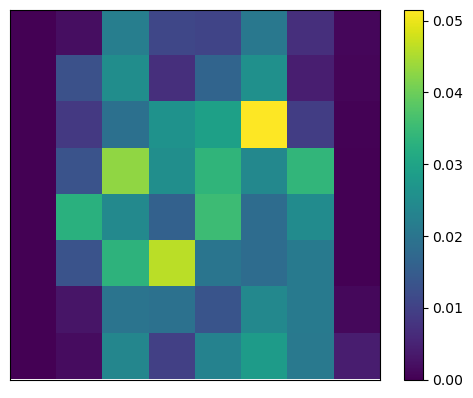

In [42]:
import_features = rnd_clf.feature_importances_.reshape(8 ,8)
plt.imshow(import_features)
plt.colorbar()
ax = plt.gca() 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


as you can see the the digits pixels where the digits lie have more importance than the one on the corners for example 

# Boosting 
the general idea behind  most boosting methods is to train  predictors sequentially , each one is trying to correct it's predecessor .
We can now iterate this procedure:

Take our model $f_k$ Compute the residuals
 
 $\epsilon _i= - \frac {\partial l_i}{\partial f( \vec{x} _i) }$

$\bullet$ Fit a model $g_k(\vec{x}_i)\approx\epsilon_i$

 Define a new model $f_k+1(\vec{x})=f_k(\vec{x})+\gamma_kg_k(\vec{x})$
where $\gamma$ is just a weight 

there are two popular ones __adaptive boosting (adaboost) and gradient boosting__

## AdaBoost
it's about paying more attention to the miss classified examples form the predecessor .



- one drawback of this technique is parallelization since each estimator is trained sequentially thus it does not scale well like bagging or pasting .
- Note we will train it over the moon dataset from earlier.

In [43]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
    
    estimator=DecisionTreeClassifier(max_depth= 1) , 
    n_estimators= 500 , learning_rate=0.5 , 
    algorithm='SAMME.R'
)
ada_clf.fit(x_train , y_train)
y_pred = ada_clf.predict(x_test)
score = accuracy_score(y_test, y_pred)
score 

/home/omar/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.8444444444444444

## math behind AdaBoost 
I will try to give the mathematical intuition of what is happening behind the scenes 
I will divide this algorithm into 6 steps you can follow through
1. first we will give equal weight to each training example we have $\frac{1}{m}$
2. take the weighted error $r_j$ of the $j^{th}$ predictor which are the weights of the miss classified examples over the whole weights.  
3. calculate the weight for the $j^{th}$ example using this equation
$\alpha_j = \eta \log\frac{1-r_j}{r_j}$ where $\eta$ is the learning rate 
as you can see the more accurate the model is the higher the $\alpha$ would be.
4.update the miss classified example with this equation $w_j = \exp(\alpha_j)$
5. then all instances are normalized 
6. the predicted class is the one that receives the majority of weighted votes $\hat y=argmax\Sigma_{j=1}^N \alpha_j$ where N is the number of classifiers

# Gradient Boosting 
it's similar to adaboost but instead of weighted instances it's trying to fit the new predictor to the residual errors made by the previous predictor.

let's check sklearn api 

In [44]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators= 500 , 
                                    learning_rate= .1)
gb_clf.fit(x_train , y_train)
y_pred = gb_clf.predict(x_test)
score = accuracy_score(y_test, y_pred)
score 

0.9629629629629629

## how to get the perfect number of estimators 
we can use early stopping technique  by utilizing `staged_predict` form sklearn

In [45]:
error = [accuracy_score(y_test, prediction) for prediction in gb_clf.staged_predict(x_test)]

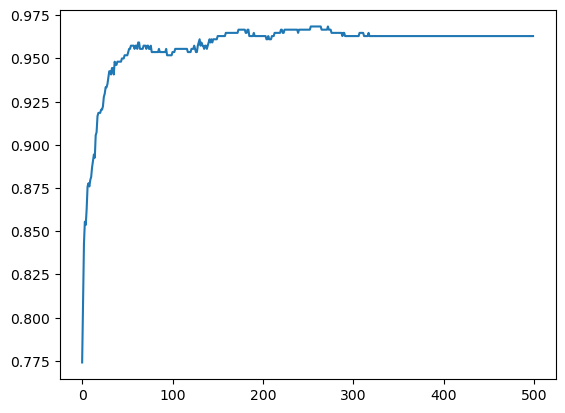

In [46]:
plt.plot(error)

In [48]:
import numpy as np
best_n_estimators = np.argmax(error)+1 
best_n_estimators

254

In [49]:
gb_clf = GradientBoostingClassifier(n_estimators= best_n_estimators , 
                                    learning_rate= .1)
gb_clf.fit(x_train , y_train)
y_pred = gb_clf.predict(x_test)
score = accuracy_score(y_test, y_pred)
score 

0.9648148148148148

In [50]:
# a more optimized version of gradient boosting is called 
# xgboost 
import xgboost 
xgb_clf = xgboost.XGBClassifier( early_stopping_rounds = 3)
xgb_clf.fit(x_train , y_train  ,eval_set=[(x_test, y_test)])
y_pred = xgb_clf.predict(x_test)
score = accuracy_score(y_test, y_pred )
score 

[0]	validation_0-mlogloss:1.37667
[1]	validation_0-mlogloss:1.05100
[2]	validation_0-mlogloss:0.84139
[3]	validation_0-mlogloss:0.69245
[4]	validation_0-mlogloss:0.58447
[5]	validation_0-mlogloss:0.50034
[6]	validation_0-mlogloss:0.43679
[7]	validation_0-mlogloss:0.38346
[8]	validation_0-mlogloss:0.33921
[9]	validation_0-mlogloss:0.30626
[10]	validation_0-mlogloss:0.27894
[11]	validation_0-mlogloss:0.25834
[12]	validation_0-mlogloss:0.23894
[13]	validation_0-mlogloss:0.22243
[14]	validation_0-mlogloss:0.20998
[15]	validation_0-mlogloss:0.20004
[16]	validation_0-mlogloss:0.19207
[17]	validation_0-mlogloss:0.18326
[18]	validation_0-mlogloss:0.17616
[19]	validation_0-mlogloss:0.17067
[20]	validation_0-mlogloss:0.16613
[21]	validation_0-mlogloss:0.16241
[22]	validation_0-mlogloss:0.15817
[23]	validation_0-mlogloss:0.15462
[24]	validation_0-mlogloss:0.15203
[25]	validation_0-mlogloss:0.14971
[26]	validation_0-mlogloss:0.14602
[27]	validation_0-mlogloss:0.14455
[28]	validation_0-mlogloss:0.1

0.9648148148148148

as you can see out of the book straight 0.867 pretty good ya !
for more info here are the [docs](https://xgboost.readthedocs.io/en/stable/python/python_api.html)

# Stacking 
it's the last ensemble method and it's also pretty straightforward , simply you train n models and you have one model that takes the input from those n models which is called the blender .
let's see the api from sklearn

In [51]:
from sklearn.ensemble import StackingClassifier
estimators = [('rf' , RandomForestClassifier(100 , max_depth=2)) ,
               ('svm' , SVC() ) , 
               ('log' , LogisticRegression())
               ]
st_clf = StackingClassifier(estimators=estimators , 
                            final_estimator= SVC()
                            )

st_clf.fit(x_train ,y_train)
y_pred = st_clf.predict(x_test)
score = accuracy_score(y_test, y_pred )
score 

/home/omar/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/omar/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

0.9777777777777777